# Código Clasificación buques mercantes utilizando 2 capas de CNN.


In [21]:
### Conocer version de paquetes y Hardware en uso
#------------------------------------------------------
#------------------------------------------------------
import sys
import tensorflow.keras
import keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Plataforma (Software-Hardware): {platform.platform()}")
print(f"Versión de Python {sys.version}")
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"versión de Pandas {pd.__version__}")
print(f"versión de Numpy {np.__version__}")
print(f"versión de Keras {keras.__version__}")
print(f"Versión de Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU está", "Disponible" if gpu else "No Disponible")
#---------------------------------------------------------

Plataforma (Software-Hardware): Windows-10-10.0.19045-SP0
Versión de Python 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Versión de TensorFlow: 2.13.0
versión de Pandas 2.0.1
versión de Numpy 1.23.5
versión de Keras 2.13.1
Versión de Scikit-Learn 1.2.2
GPU está No Disponible


## Cargamos las librerias necesarias

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.activations import relu
from keras.preprocessing.image import ImageDataGenerator

## Cargamos las imagenes

In [23]:
import os
import cv2
import numpy as np
from PIL import Image

altura, longitud = 100, 100

def cargar_y_redimensionar_imagenes(ruta):
    imagenes_redimensionadas = []
    for archivo in os.listdir(ruta):
        archivo_ruta = os.path.join(ruta, archivo)
        # Verificamos si el archivo es una imagen válida antes de abrirlo con OpenCV
        imagen = cv2.imread(archivo_ruta)
        if imagen is not None and len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.resize(imagen, (altura, longitud))
            imagenes_redimensionadas.append(imagen)
    return imagenes_redimensionadas

# Rutas de los directorios de imágenes
ruta_mercantes = './datos/mercantes'
ruta_otros = './datos/otros'

# Cargar y redimensionar imágenes de mercantes y otros
imagenes_mercantes = cargar_y_redimensionar_imagenes(ruta_mercantes)
imagenes_otros = cargar_y_redimensionar_imagenes(ruta_otros)

# Obtener la cantidad de imágenes en cada directorio
dircount = [len(imagenes_mercantes), len(imagenes_otros)]

print('Imagenes en cada directorio:', dircount)
print('Suma Total de imagenes en subdirectorios:', sum(dircount))

Imagenes en cada directorio: [56, 35]
Suma Total de imagenes en subdirectorios: 91


## Crear etiquetas y clases

**Creamos los labels con valor 1 para mercante y 0 para otros**

In [24]:
# Crear una lista de etiquetas (0 para mercantes, 1 para otros)
etiquetas_mercantes = [0] * len(imagenes_mercantes)
etiquetas_otros = [1] * len(imagenes_otros)

# Combinar las imágenes y etiquetas en un solo conjunto de datos
imagenes = imagenes_mercantes + imagenes_otros
etiquetas = etiquetas_mercantes + etiquetas_otros

## Muestra de Imágenes:

Text(0.5, 1.0, 'Imagen con etiqueta Mercante')

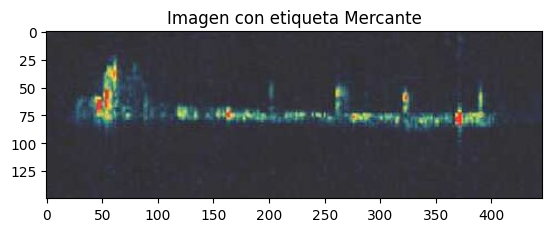

In [25]:
# Muestra de Etiqueta Mercante:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('datos/mercantes/10.jpg'))
plt.title("Imagen con etiqueta Mercante")

Text(0.5, 1.0, 'Imagen con etiqueta Otros')

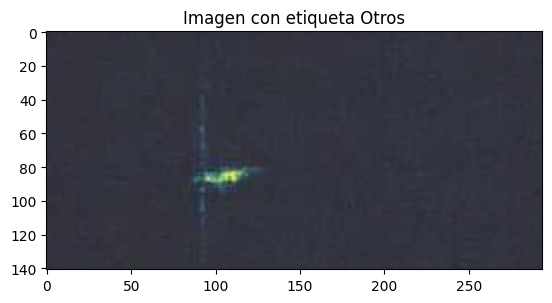

In [26]:
# Muestra de Etiqueta Otros:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('datos/otros/11.jpg'))
plt.title("Imagen con etiqueta Otros")

## Creamos sets de Entrenamiento y Test

In [27]:
# Convertir a arreglos NumPy
X = np.array(imagenes, dtype=np.uint8)
y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y validación (80% para entrenamiento, 20% para validación)
train_X, valid_X, train_label, valid_label = train_test_split(X, y, test_size=0.2, random_state=218) #num de cadete

train_X = train_X / 255.
valid_X = valid_X / 255.

# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs:', nClasses)
print('Output classes:', classes)

train_label_one_hot = to_categorical(train_label, num_classes=nClasses)
valid_label_one_hot = to_categorical(valid_label, num_classes=nClasses)

Total number of outputs: 2
Output classes: [0 1]


## Data augmentation

In [28]:
# Configurar las transformaciones de data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # Rango de rotación aleatoria (en grados)
    width_shift_range=0.2,     # Rango de traslación horizontal aleatoria (como fracción del ancho total)
    height_shift_range=0.2,    # Rango de traslación vertical aleatoria (como fracción del alto total)
    shear_range=0.2,           # Rango de cizallamiento (shear) aleatorio
    zoom_range=0.2,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Modo de rellenado para las transformaciones
)

## Creamos la red neuronal de 2 capas

### Dropout (0.3)

In [29]:
INIT_LR = 0.0001#1e-3 

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
filtrosConv3=128
tamano_filtro1=(5,5)
tamano_filtro2=(3,3)
tamano_pool=(2,2)

modelo1 = Sequential(name='dropout_0.3')
modelo1.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo1.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo1.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo1.add(MaxPooling2D(pool_size=tamano_pool))

#tercera capa de convolucion
modelo1.add(Convolution2D(filtrosConv3, tamano_filtro2, padding='same', activation='relu'))

#capa que aplana la imagen (1D)
modelo1.add(Flatten())

#capa normal, de 256 neuronas
modelo1.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo1.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo1.add(Dense(nClasses,activation='softmax'))

#con Graphviz se puede hacer un diagrama de flujo para ver la logica del sistema
modelo1.summary()

modelo1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "dropout_0.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 flatten_3 (Flatten)         (None, 80000)             

### Dropout (0.5)

In [30]:
INIT_LR = 0.0001#1e-3 

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
filtrosConv3=128
tamano_filtro1=(5,5)
tamano_filtro2=(3,3)
tamano_pool=(2,2)

modelo2 = Sequential(name='dropout_0.5')
modelo2.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo2.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo2.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo2.add(MaxPooling2D(pool_size=tamano_pool))

#tercera capa de convolucion
modelo2.add(Convolution2D(filtrosConv3, tamano_filtro2, padding='same', activation='relu'))

#capa que aplana la imagen (1D)
modelo2.add(Flatten())

#capa normal, de 256 neuronas
modelo2.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo2.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo2.add(Dense(nClasses,activation='softmax'))

#con Graphviz se puede hacer un diagrama de flujo para ver la logica del sistema
modelo2.summary()

modelo2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "dropout_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 80000)             

### Dropout (0.7)

In [31]:
INIT_LR = 0.0001#1e-3 

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
filtrosConv3=128
tamano_filtro1=(5,5)
tamano_filtro2=(3,3)
tamano_pool=(2,2)

modelo3 = Sequential(name='dropout_0.7')
modelo3.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo3.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo3.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo3.add(MaxPooling2D(pool_size=tamano_pool))

#tercera capa de convolucion
modelo3.add(Convolution2D(filtrosConv3, tamano_filtro2, padding='same', activation='relu'))

#capa que aplana la imagen (1D)
modelo3.add(Flatten())

#capa normal, de 256 neuronas
modelo3.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo3.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo3.add(Dense(nClasses,activation='softmax'))

#con Graphviz se puede hacer un diagrama de flujo para ver la logica del sistema
modelo3.summary()

modelo3.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "dropout_0.7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 25, 25, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 flatten_5 (Flatten)         (None, 80000)             

## Entrenamos la red


### Dropout 0.3

In [32]:
epochs = 200
batch_size = 32

# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

## Modifica el train_x para incluir las imagenes del train_data_generator
history1=modelo1.fit(train_data_generator, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label_one_hot))

Epoch 1/200
2/2 [==============================] - 3s 1s/step - loss: 0.6895 - accuracy: 0.6250 - val_loss: 0.6433 - val_accuracy: 0.6316
Epoch 2/200
2/2 [==============================] - 1s 530ms/step - loss: 0.6985 - accuracy: 0.6250 - val_loss: 0.6437 - val_accuracy: 0.6316
Epoch 3/200
2/2 [==============================] - 1s 465ms/step - loss: 0.6703 - accuracy: 0.6250 - val_loss: 0.6502 - val_accuracy: 0.6316
Epoch 4/200
2/2 [==============================] - 1s 445ms/step - loss: 0.6754 - accuracy: 0.6000 - val_loss: 0.6365 - val_accuracy: 0.6316
Epoch 5/200
2/2 [==============================] - 1s 484ms/step - loss: 0.6822 - accuracy: 0.5500 - val_loss: 0.6412 - val_accuracy: 0.6316
Epoch 6/200
2/2 [==============================] - 1s 744ms/step - loss: 0.6796 - accuracy: 0.6000 - val_loss: 0.6425 - val_accuracy: 0.6316
Epoch 7/200
2/2 [==============================] - 1s 778ms/step - loss: 0.6672 - accuracy: 0.6500 - val_loss: 0.6494 - val_accuracy: 0.6316
Epoch 8/200
2/2 

### Dropout 0.5

In [33]:
# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

## Modifica el train_x para incluir las imagenes del train_data_generator
history2=modelo2.fit(train_data_generator, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label_one_hot))

Epoch 1/200
2/2 [==============================] - 3s 863ms/step - loss: 0.6831 - accuracy: 0.6000 - val_loss: 0.6477 - val_accuracy: 0.6316
Epoch 2/200
2/2 [==============================] - 1s 617ms/step - loss: 0.7157 - accuracy: 0.5938 - val_loss: 0.6475 - val_accuracy: 0.6316
Epoch 3/200
2/2 [==============================] - 1s 634ms/step - loss: 0.6785 - accuracy: 0.6094 - val_loss: 0.6447 - val_accuracy: 0.6316
Epoch 4/200
2/2 [==============================] - 1s 622ms/step - loss: 0.6949 - accuracy: 0.5250 - val_loss: 0.6972 - val_accuracy: 0.4211
Epoch 5/200
2/2 [==============================] - 1s 615ms/step - loss: 0.6832 - accuracy: 0.5500 - val_loss: 0.6696 - val_accuracy: 0.7895
Epoch 6/200
2/2 [==============================] - 1s 619ms/step - loss: 0.6759 - accuracy: 0.5469 - val_loss: 0.6430 - val_accuracy: 0.6316
Epoch 7/200
2/2 [==============================] - 1s 380ms/step - loss: 0.6349 - accuracy: 0.6500 - val_loss: 0.6345 - val_accuracy: 0.6316
Epoch 8/200
2

### Dropout 0.7

In [34]:
# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

## Modifica el train_x para incluir las imagenes del train_data_generator
history3=modelo3.fit(train_data_generator, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label_one_hot))

Epoch 1/200
2/2 [==============================] - 3s 846ms/step - loss: 0.7146 - accuracy: 0.4844 - val_loss: 0.6523 - val_accuracy: 0.6316
Epoch 2/200
2/2 [==============================] - 1s 599ms/step - loss: 0.6989 - accuracy: 0.6094 - val_loss: 0.6450 - val_accuracy: 0.6316
Epoch 3/200
2/2 [==============================] - 1s 603ms/step - loss: 0.6635 - accuracy: 0.6250 - val_loss: 0.6501 - val_accuracy: 0.6316
Epoch 4/200
2/2 [==============================] - 1s 361ms/step - loss: 0.6869 - accuracy: 0.6250 - val_loss: 0.6405 - val_accuracy: 0.6316
Epoch 5/200
2/2 [==============================] - 1s 633ms/step - loss: 0.6322 - accuracy: 0.7000 - val_loss: 0.6350 - val_accuracy: 0.6316
Epoch 6/200
2/2 [==============================] - 2s 781ms/step - loss: 0.6847 - accuracy: 0.6250 - val_loss: 0.6416 - val_accuracy: 0.6316
Epoch 7/200
2/2 [==============================] - 1s 614ms/step - loss: 0.6252 - accuracy: 0.6719 - val_loss: 0.6457 - val_accuracy: 0.6316
Epoch 8/200
2

## Obtenemos las métricas de entrenamiento y validación, luego graficamos

In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def metricas(clases_reales, clases_predichas):
    matriz_conf=confusion_matrix(clases_reales, clases_predichas)
    accuracy=accuracy_score(clases_reales,clases_predichas)
    precision=precision_score(clases_reales,clases_predichas)
    recall=recall_score(clases_reales,clases_predichas)
    f1=f1_score(clases_reales,clases_predichas)
    return matriz_conf, accuracy, recall, precision, f1

def visualizar_metricas(clases_reales,clases_predichas, titulo):
    #Calculamos metricas con la funcion previa
    matriz, accuracy, recall, precision, f1=metricas(clases_reales,clases_predichas)

    #Graficamos
    plt.figure(figsize=(3,3))
    matriz=pd.DataFrame(matriz,columns=['0: Mercante', '1: Otro'])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)    
    plt.show()
    print("\n")

#print("\n")

#reales=[1,1,0,0,0,0,1,1]
#predichas=[1,1,0,1,0,1,1,1]

#visualizar_metricas(reales,predichas,'Métricas')

## Métricas dropout 0.3

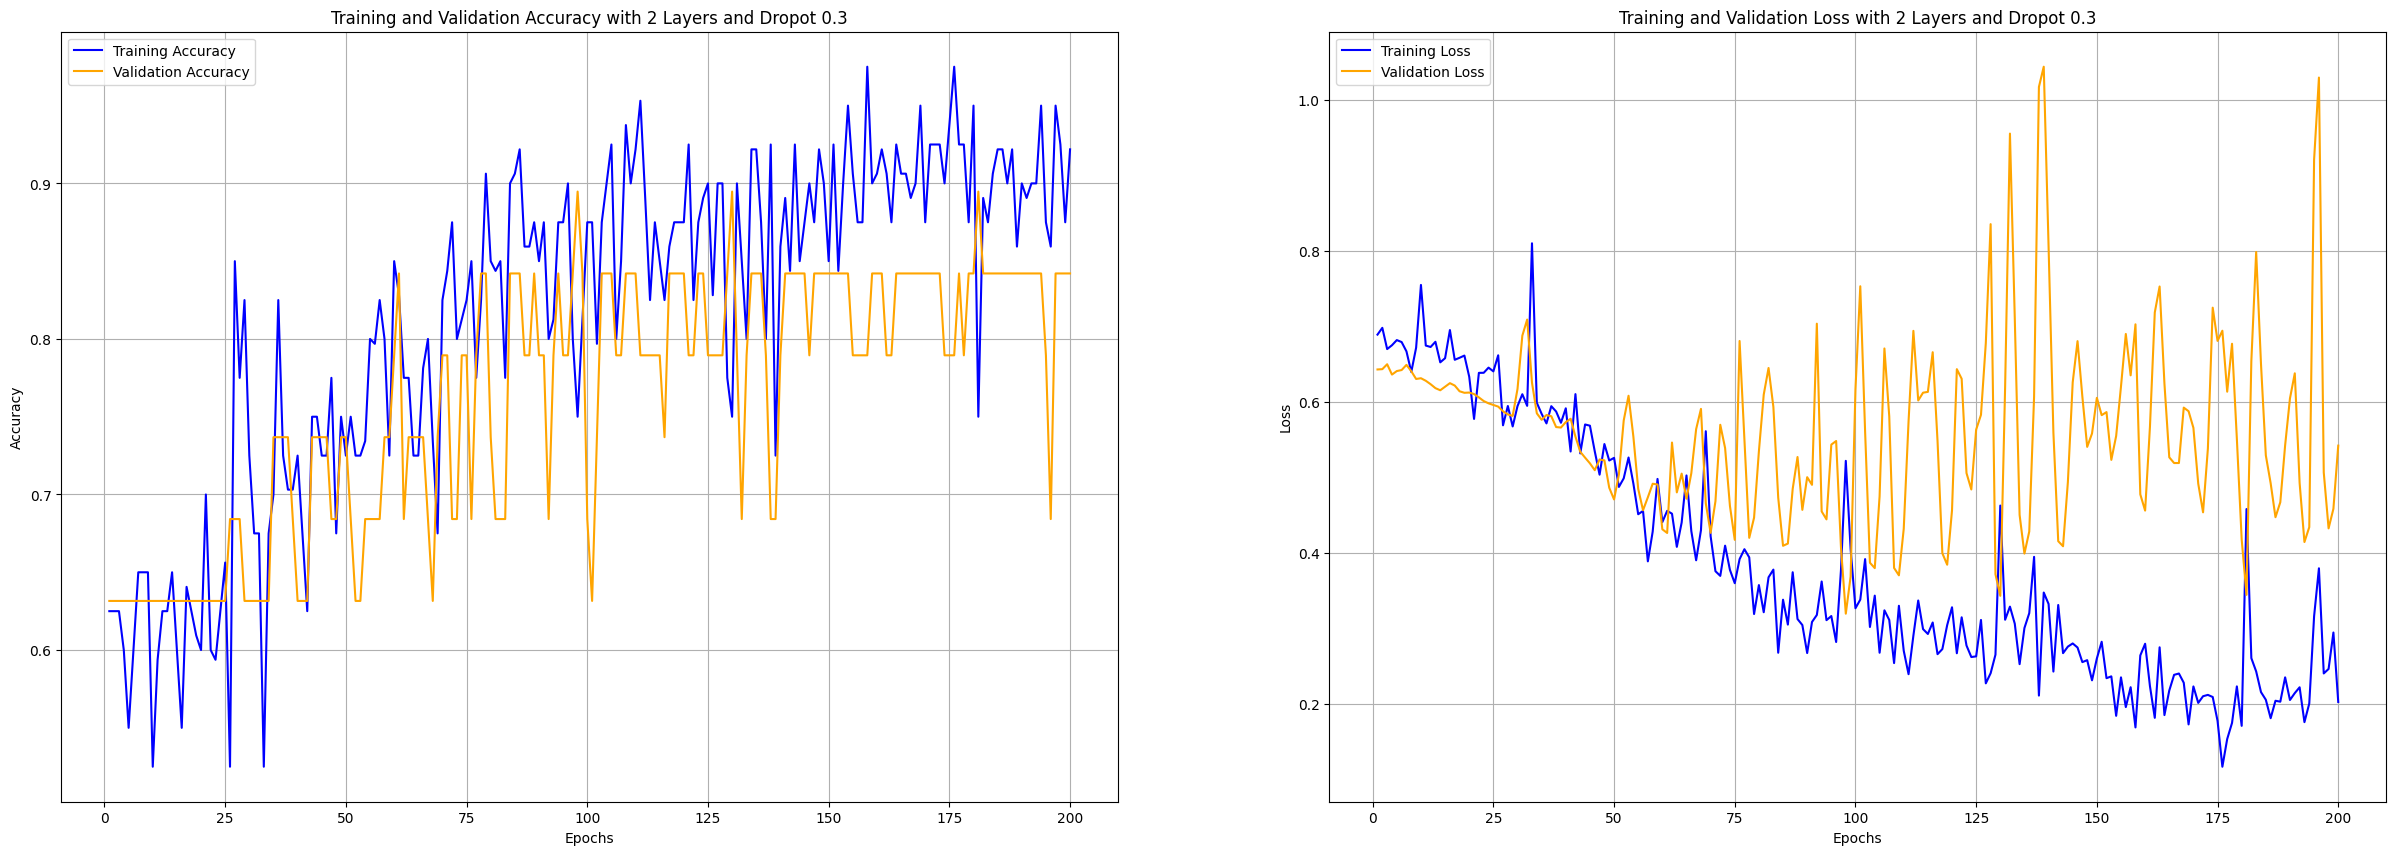

In [45]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(30,10))

# Gráfica de precisión (accuracy)
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with 2 Layers and Dropot 0.3')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
# Gráfica de pérdida (loss)
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with 2 Layers and Dropot 0.3')
plt.legend()
plt.grid(True)
plt.show()

## Métricas dropout 0.5

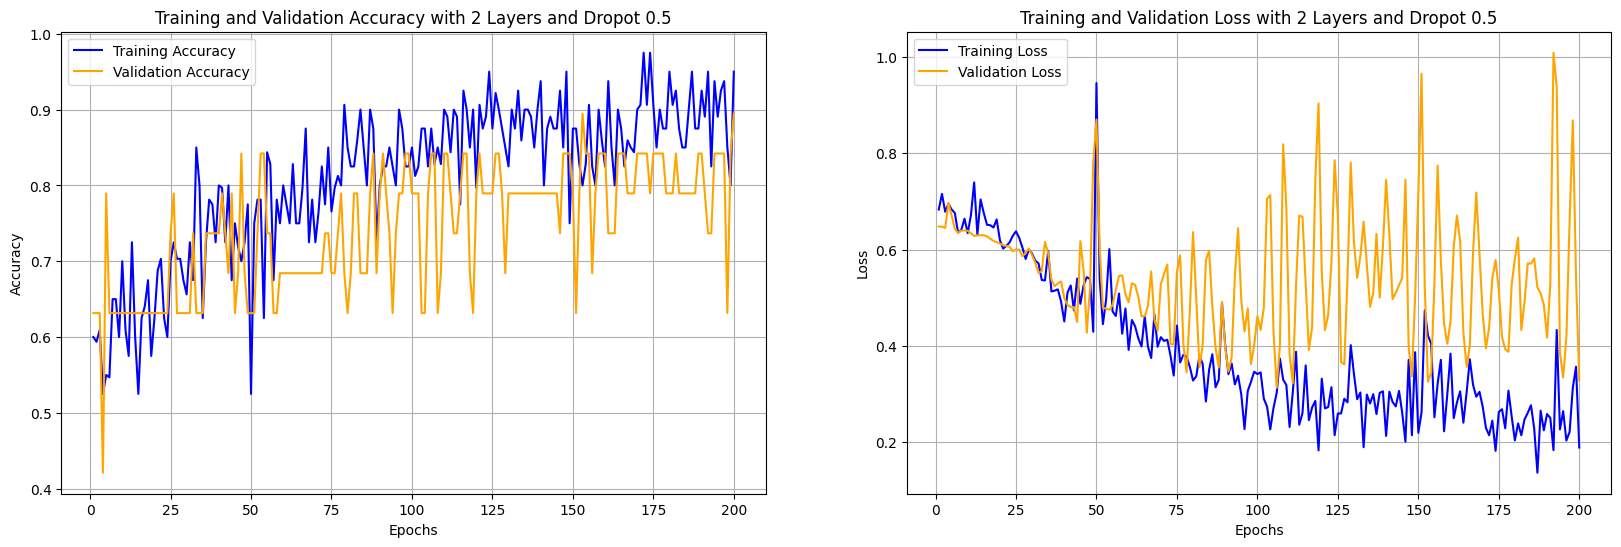

In [41]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(20,6))

# Gráfica de precisión (accuracy)
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with 2 Layers and Dropot 0.5')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
# Gráfica de pérdida (loss)
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with 2 Layers and Dropot 0.5')
plt.legend()
plt.grid(True)
plt.show()

## Métricas dropout 0.7

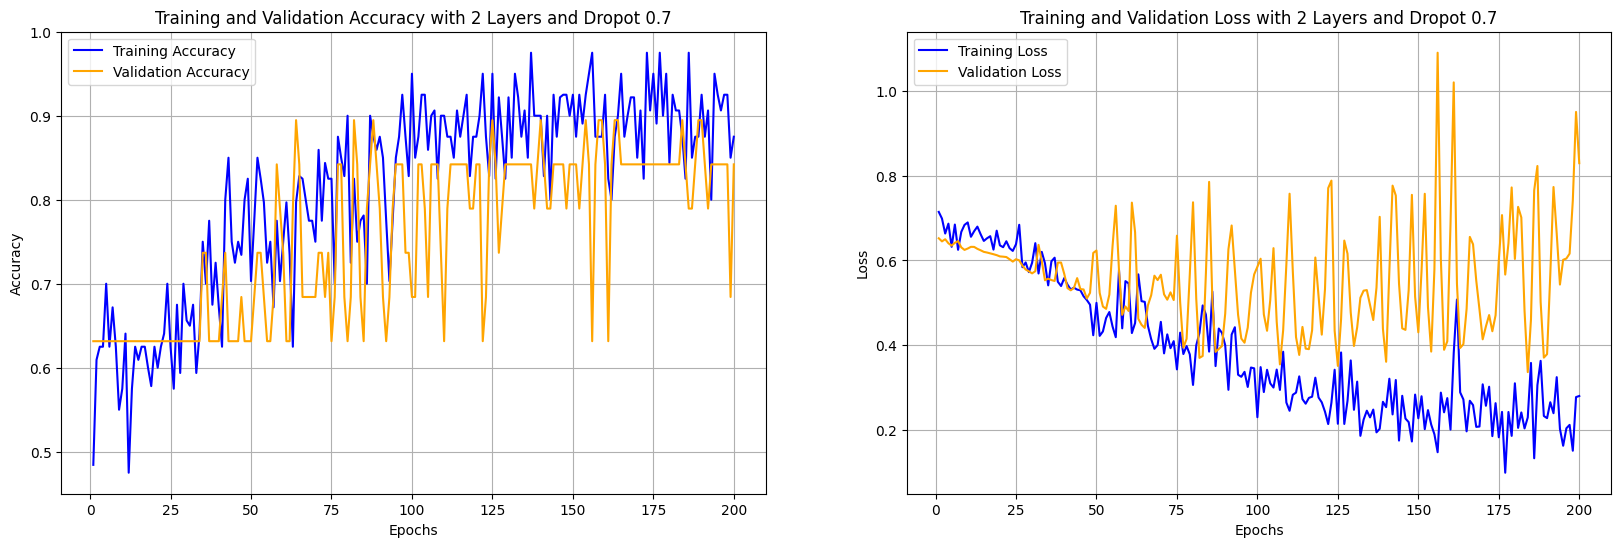

In [42]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(20,6))

# Gráfica de precisión (accuracy)
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with 2 Layers and Dropot 0.7')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
# Gráfica de pérdida (loss)
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with 2 Layers and Dropot 0.7')
plt.legend()
plt.grid(True)
plt.show()

## Probamos la red

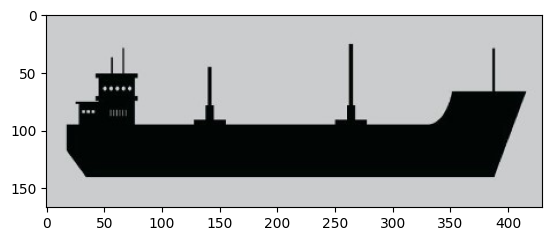

In [39]:
# Muestra de Etiqueta Mercante:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('prueba/4.jpg'))

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

directorio_imagen_prueba='./prueba/4.jpg'
# Carga la imagen de prueba
imagen_prueba = cv2.imread(directorio_imagen_prueba)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))

# OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

# Convertir a float32 y normalizar
imagen_prueba = imagen_prueba.astype('float32') / 255.0

# Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

# Obtén las predicciones utilizando el modelo entrenado
predicciones = modelo.predict(imagen_prueba)

# Las predicciones son un arreglo de probabilidades, conviértelas a una clase
clase_predicha = np.argmax(predicciones[0])

# Obten la clase correspondiente al índice
clase = classes[clase_predicha]

# Obten el porcentaje de confianza para la clase predicha
porcentaje_confianza = predicciones[0][clase_predicha] * 100

# Carga la imagen de nuevo para mostrarla (esta vez en formato RGB para matplotlib)
imagen_prueba = cv2.cvtColor(cv2.imread(directorio_imagen_prueba), cv2.COLOR_BGR2RGB)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))
imagen_array = np.array(imagen_prueba) # Arreglo de pixeles de la imagen

plt.imshow(imagen_prueba)
plt.title("La imagen es de clase: {} con un porcentaje de confianza de: {:.2f}%".format(clase, porcentaje_confianza))
plt.show()

imagen_prueba1=cv2.resize(imagen_prueba, (30, 30))
imagen_array1=np.array(imagen_prueba1)
# Aproximar los valores de píxeles a la unidad
imagen_pixeles = np.round(color.rgb2gray(imagen_array1) * 255).astype(int)

np.set_printoptions(linewidth=np.inf)
print(f'\nArreglo de pixeles de la imagen:\n {imagen_pixeles}') #Valores entre 0 y 255

NameError: name 'modelo' is not defined

In [ ]:
def prueba_modelo(modelo, directorio, altura, longitud, classes):
    resultados = []
    for archivo in os.listdir(directorio):
        ruta_imagen = os.path.join(directorio, archivo)
        # Carga la imagen de prueba
        imagen_prueba = cv2.imread(ruta_imagen)
        imagen_prueba = cv2.resize(imagen_prueba, (altura, longitud))

        # OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
        imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

        # Convertir a float32 y normalizar
        imagen_prueba = imagen_prueba.astype('float32') / 255.0

        # Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
        imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

        # Obtén las predicciones utilizando el modelo entrenado
        predicciones = modelo.predict(imagen_prueba)

        # Las predicciones son un arreglo de probabilidades, conviértelas a una clase
        clase_predicha = np.argmax(predicciones[0])

        # Obten la clase correspondiente al índice
        clase = classes[clase_predicha]

        resultados.append((archivo, clase))

    return resultados

# Uso de la función prueba_modelo
directorio_imagenes = './prueba'
resultados = prueba_modelo(modelo, directorio_imagenes, altura, longitud, classes)

# Mostrar resultados
for archivo, clase in resultados:
    print(f"La imagen {archivo} es de clase: {clase}")

1/1 [==============================] - 0s 48ms/step
La imagen 1.jpg es de clase: 0
La imagen 2.png es de clase: 0
La imagen 3.jpg es de clase: 0
La imagen 4.jpg es de clase: 0
La imagen 5.jpg es de clase: 0
La imagen 6.jpg es de clase: 0
La imagen 7.jpg es de clase: 0
La imagen 8.jpg es de clase: 0
